#Logistic optimization using Genetic algorithm
## Problem description
There are 10 offshore locations that needs maintenance. Every location may need maintainance with a probability *p* and the number of staff needed at any of these locations can vary between $[1,N_s]$ with a uniform probability. 

The total number of available staff on any given day varies with a normal distribution with mean $\mu$ and standard deviation $\sigma$.

Finally there are four available vehicles with seating capacities 15, 15, 25, 25.

The goal is to find a team composition that matches the demand as much as possible, minimize the number of vehicles and maximize staff deployment. Preference should be given to high-priority locations.

An example input for any random day:
Staff supply:   65 \\
Demand : $[0, 13, 3, 14, 13, 8, 0, 10, 7, 0](68)$ \\
Priority:   $[1, 1, 2, 2, 2, 1, 2, 1, 1, 1]$ (2 means a high priority location and 1 means a low priority location)

The output may look something like this:

Teams assigned: 
L1: $[0]$   L2:$[6, 7]$  L3:$[3]$  L4:$[7, 7]$ so on

Selected vehicles:[15, 25, 25] 

## Assumpitions and constraints:
Team size can be between 1 to 8

Cannot split a team into two vehicles

Possible to assign multiple teams to a single location

Cost of flight time and number of landings are negligible

When demand > supply, assign teams to as many locations as possible


In [1]:
# Ortools is needed to solve a bin packing problems. For the above problem, we need to fit the assigned teams with a minimum number of vehicles, similar to bin packing.
!pip install ortools

     |████████████████████████████████| 32.7MB 120kB/s 


In [2]:
import numpy as np
from random import randint
from __future__ import print_function
from ortools.linear_solver import pywraplp
import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from copy import deepcopy

# Creating input data

This method returns a dictionary with a random supply demand for a day.

In [3]:
def create_input_data():
  # total number of offshore locations
  num_assets = 10
  # Priorities of 10 locations. 2- High priority 1- low priority
  asset_priority = [1,1,2,2,2,1,1,2,1,1]

  # probability p that an asset will require maintenance, and min and max limit for number of staffs required at any location
  prob_need_maintenance = 0.3
  min_staff_needed = 1
  max_staff_needed =16
  
  # Generate random demand
  need_maintenance =  np.random.uniform(0,1,num_assets)> prob_need_maintenance # np.array[Bool] of size num_asset. True if an asset need maintenance. 
  staff_needed_per_asset = np.multiply(np.random.randint(min_staff_needed, max_staff_needed, num_assets),need_maintenance) # array of intergers representing number of workers needed at a location
  
  # Vehicle capacities
  capacity_vehicles = [15, 15, 25, 25] 

  # Mean and std for staff availability
  mu_staff = 70
  sigma_staff = 20

  # Range for a single team size
  min_team_size = 1
  max_team_size = 8

  # Generate staff supply and check if Gaussian distribution gives a positive value
  total_staff = int(np.ceil(np.random.normal(mu_staff, sigma_staff, 1))[0]) # sample number of staffs
  if(total_staff <= 0):
    total_staff = 1
    
  # Dict to store all input data
  input_data = {}
  input_data['num_assets'] = num_assets
  input_data['need_maintenance'] = need_maintenance.astype(int).tolist()
  input_data['asset_priority'] = asset_priority
  input_data['staff_needed_per_asset'] = staff_needed_per_asset.tolist()
  input_data['capacity_vehicles'] = capacity_vehicles
  input_data['max_team_size'] = max_team_size
  input_data['min_team_size'] = min_team_size
  input_data['total_staff'] = total_staff
  return input_data

# Sampling a random team composition
## Given
Staff supply:   65
Demand : [0, 13, 3, 14, 13, 8, 0, 10, 7, 0](68)
Priority:   [1, 1, 2, 2, 2, 1, 2, 1, 1, 1]
Allowed team size: [1, 8]

## Steps to generate a team set
Randomly split total staffs into teams: [7, 4, 7, 2, 6, 5, 6, 4, 6, 4, 4, 3, 5, 2] (65)

Assign teams to high priority location: [[3],[7,7],[6,5,2],[0]]

Assign to low priority locations: [[0], [6,5,2], [4,4],[6,4],[4],[0]]

Randomly assign leftover teams to locations


In [5]:
def sample_teams(total_staff, min_team_size, max_team_size,staff_needed_per_asset, asset_priority,capacity_vehicles):

  # modify the max_team_size if the demand > supply
  if (total_staff<sum(staff_needed_per_asset)):
    max_team_size = min(max_team_size,int(max_team_size*total_staff/sum(staff_needed_per_asset)))
  else:
    max_team_size = min(max_team_size,int(max_team_size*sum(staff_needed_per_asset)/total_staff))
    total_staff = randint(sum(staff_needed_per_asset),total_staff)
  if (max_team_size<1):
    max_team_size = 1

  # Create splits. Initial team consist of broken random broken chunks of total_staff
  initial_teams = []
  while (True):
    team = randint(min_team_size, max_team_size)
    if (team + sum(initial_teams) > total_staff):
      break
    if (team>0):
      initial_teams.append(team)
  if (total_staff - sum(initial_teams)>0):
    initial_teams.append(total_staff - sum(initial_teams))

  # sort based on priority of locations
  sorted_index_asset_priority = np.argsort(asset_priority).tolist()
  sorted_index_asset_priority = sorted_index_asset_priority[::-1] # descending order

  # split into main and extra teams
  main_teams = []
  priority = []
  demand = []
  teams_counter = 0

  # Distribute teams such that high priority locations are filled first and then low priority ones
  while (len(initial_teams) > 0 and teams_counter < len(staff_needed_per_asset)):
    staff_needed = staff_needed_per_asset[sorted_index_asset_priority[teams_counter]]
    demand.append(staff_needed)
    priority.append(asset_priority[sorted_index_asset_priority[teams_counter]])
    if (staff_needed == 0):
      main_teams.append([0])
    else:
      teams_per_location = []
      while(staff_needed > 0 and len(initial_teams) > 0):
        index_min = 0
        difference = 999 # a large value
        for i in range(len(initial_teams)):
          if(abs(staff_needed - initial_teams[i]) < difference):
            index_min = i
            difference = abs(staff_needed - initial_teams[i])
        teams_per_location.append(initial_teams[index_min])
        staff_needed = staff_needed - initial_teams[index_min]
        initial_teams.pop(index_min)
      main_teams.append(teams_per_location)
    teams_counter = teams_counter+1
  
  # Append zeros if the length of team set is less than number of assets
  while (teams_counter < len(staff_needed_per_asset)):
    main_teams.append([0])
    staff_needed = staff_needed_per_asset[sorted_index_asset_priority[teams_counter]]
    demand.append(staff_needed)
    priority.append(asset_priority[sorted_index_asset_priority[teams_counter]])
    teams_counter = teams_counter+1

  # Randomly assign leftover teams
  while (len(initial_teams)>0):
    random_index = randint(0,len(staff_needed_per_asset)-1)
    if(sum(main_teams[random_index])>0):
      main_teams[random_index].append(initial_teams[0])
      initial_teams.pop(0)
  return demand, priority, main_teams

In [6]:
# Adopted from Google Ortools tutorial
def bin_packing(weights,bin_capacity):
    data = {}
    data['weights'] = weights
    data['items'] = list(range(len(weights)))
    data['bins'] = list(range(len(bin_capacity)))
    data['bin_capacity'] = bin_capacity
    
    bin_number_list = []
    bin_items_list = []
    bin_weight_list = []

    # Create the mip solver with the CBC backend.
    solver = pywraplp.Solver('bin_packing_mip',pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    # Variables
    # x[i, j] = 1 if item i is packed in bin j.
    x = {}
    for i in data['items']:
        for j in data['bins']:
            x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j))

    # y[j] = 1 if bin j is used.
    y = {}
    for j in data['bins']:
        y[j] = solver.IntVar(0, 1, 'y[%i]' % j)

    # Constraints
    # Each item must be in exactly one bin.
    for i in data['items']:
        solver.Add(sum(x[i, j] for j in data['bins']) == 1)

    # The amount packed in each bin cannot exceed its capacity.
    for j in data['bins']:
        solver.Add(
            sum(x[(i, j)] * data['weights'][i] for i in data['items']) <= y[j] *
            data['bin_capacity'][j])

    # Objective: minimize the number of bins used.
    solver.Minimize(solver.Sum([y[j] for j in data['bins']]))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        for j in data['bins']:
            if y[j].solution_value() == 1:
                bin_items = []
                bin_weight = 0
                for i in data['items']:
                    if x[i, j].solution_value() > 0:
                        bin_items.append(i)
                        bin_weight += data['weights'][i]
                if bin_weight > 0:
                    bin_number_list.append(j)
                    bin_items_list.append(bin_items)
                    bin_weight_list.append(bin_weight)
        return bin_weight_list
    else:
        return bin_weight_list

# Compute fitness of a team composition
For every candidate team compositions:

1. Penalty for unmet demand at a location
```
C_0 * priority(loc)x(demand(loc) - supply(loc))
```

2. Penalty for no team assigned to a location with demand
		C1*priority(loc)

3. Vehicle utilization
```  
sum(loads on selected vehicle) + C2*sum(empty seats) 
```
      [to avoid cases like [25, 15, 1]]	

4. Cost for unassigned staff
```
C3*(staffs onshore)
```

In [7]:
def cal_pop_cost(total_staff_available, selected_teams, asset_priority, staff_needed_per_asset, capacity_vehicles, penalty_no_team_assigned):

  # Found using trial and error
  C0 = 2
  C1 = penalty_no_team_assigned
  C2 = 4
  C3 = 0.25

  # cost due to unmet demand per asset
  cost_unmet_demand = 0
  for i in range(len(staff_needed_per_asset)):
    cost_unmet_demand = cost_unmet_demand + C0*asset_priority[i]*max(0,staff_needed_per_asset[i] - sum(selected_teams[i]))
  
  # penalty for having no teams at an asset which need some maintainance
  cost_no_team_assigned = 0
  for i in range(len(staff_needed_per_asset)):
    if (staff_needed_per_asset[i]>0 and sum(selected_teams[i]) == 0):
      cost_no_team_assigned = cost_no_team_assigned + asset_priority[i]*C1

  # cost due to vehicle filling
  # first flatten the list of list
  flat_team_list = []
  for sublist in selected_teams:
    for item in sublist:
        flat_team_list.append(item)    
  vehicle_loads = bin_packing(flat_team_list, capacity_vehicles)
  vehicle_counter = 0
  selected_vehicles = []
  while (len(vehicle_loads) > vehicle_counter):
    vehicle_load = vehicle_loads[vehicle_counter]
    index_min = 0
    difference = 25
    for i in range(len(capacity_vehicles)):
      if (capacity_vehicles[i] - vehicle_load >= 0 and capacity_vehicles[i] - vehicle_load < difference):
        difference = capacity_vehicles[i] - vehicle_load
        index_min = i 
    selected_vehicles.append(capacity_vehicles[index_min])
    capacity_vehicles.pop(index_min)
    vehicle_counter = vehicle_counter + 1
  if (len(vehicle_loads) == 0):
    cost_vehicle = sum(capacity_vehicles)
  else:
    # cost_vehicle = sum(selected_vehicles)
    cost_empty_seat = 0
    for i in range(len(selected_vehicles)):
      cost_empty_seat  = cost_empty_seat + selected_vehicles[i] - vehicle_loads[i]
    cost_vehicle = sum(vehicle_loads) + C2*cost_empty_seat 

  #cost of unused staff
  cost_unused_staff = C3*(total_staff_available - sum(flat_team_list))
  cost = cost_unused_staff + cost_no_team_assigned + cost_unmet_demand + cost_vehicle
  return cost

In [8]:
# Given a list of teams and capacities of vehicles, returns the minimum number of vehicles needed to fill all teams. Solves the bin packing packing problem
def vehicle_utilization(selected_teams, capacity_vehicles):
  flat_team_list = []
  for sublist in selected_teams:
    for item in sublist:
        flat_team_list.append(item)    
  vehicle_loads = bin_packing(flat_team_list, capacity_vehicles)
  vehicle_counter = 0
  selected_vehicles = []
  while (len(vehicle_loads) > vehicle_counter):
    vehicle_load = vehicle_loads[vehicle_counter]
    index_min = 0
    difference = 25
    for i in range(len(capacity_vehicles)):
      if(capacity_vehicles[i] - vehicle_load >= 0 and capacity_vehicles[i] - vehicle_load < difference):
        difference = capacity_vehicles[i] - vehicle_load
        index_min = i 
    selected_vehicles.append(capacity_vehicles[index_min])
    capacity_vehicles.pop(index_min)
    vehicle_counter = vehicle_counter + 1
  if(len(vehicle_loads) == 0):
    return capacity_vehicles
  else:
    return vehicle_loads

# Selecting a mating pool from a population. 
Uses *k*-tournament selection approach

In [9]:
def select_mating_pool(k, selection_prob, population, cost, num_parents_mating):
  parents = []
  #k-tournament selection
  while (len(parents)< num_parents_mating and len(population)>k):
    k_samples = []
    cost_samples = []
    while (len(k_samples)<=k): # select randomly k individuals
      random_index = random.randrange(len(population))
      if (random_index not in k_samples):
        k_samples.append(random_index)
        cost_samples.append(cost[random_index])
    index_min_cost = min(range(len(cost_samples)), key=cost_samples.__getitem__)
    if (random.uniform(0,1) > selection_prob):
      selection_prob = selection_prob*(1-selection_prob)
      parents.append(population[index_min_cost])
      population.pop(index_min_cost)
      cost.pop(index_min_cost)
  return parents

#Crossover 
##Combine two fit parents to produce offsprings:

Choose two parents
```
P1: [[7, 4], [7, 2],    [0], [6], [5], [0], [6, 4],  [6], [4, 4], [3, 5, 2]]
P2: [[5, 3], [7, 2, 3], [0], [6], [5], [0], [5,1,4], [6], [7, 1], [6, 4]]
```
Randomly choose one location:
```
P1: [[7, 4], [7, 2],    [0], [6], [5], [0],  **[6, 4]**,  [6], [4, 4], [3, 5, 2]]
P2: [[5, 3], [7, 2, 3], [0], [6], [5], [0],  **[5,1,4]**, [6], [7, 1], [6, 4]]
```
Exchange the teams if sum of teams are same
```
C1: [[7, 4], [7, 2],    [0], [6], [5], [0], **[5,1,4]**,  [6], [4, 4], [3, 5, 2]]
C2: [[5, 3], [7, 2, 3], [0], [6], [5], [0], **[6, 4]**,   [6], [7, 1], [6, 4]]
```


The number of crossover location is a parameter (*max_crossover_locations*)

In [10]:
def crossover(parents,max_crossover_locations):
  num_parents = len(parents)
  offsprings = []
  for i in range(num_parents):
    p1 = deepcopy(parents[i%num_parents])
    p2 = deepcopy(parents[(i+1)%num_parents])
    new_offspring = False
    for j in range(max_crossover_locations):
      random_index = random.randrange(len(p1))
      if (sum(p1[random_index]) == sum(p2[random_index])):
        new_offspring = True
        temp = deepcopy(p1[random_index])
        p1[random_index] = deepcopy(p2[random_index])
        p2[random_index] = deepcopy(temp)
    if (new_offspring):
      offsprings.append(p1)
      offsprings.append(p2)
  return parents + offsprings

# Mutation
Consists of two steps:

##Swapping
Randomly swap teams between two locations
```
[[5, 3], [7, 2, 3], [0], [6], [5], [0], [6, 4], [6], [7, 1], [6, 4]]
[[6, 3], [7, 2, 3], [0], [5], [5], [0], [6, 4], [6], [7, 1], [6, 4]]
```
##Dropout
Randomly remove a team assigned to a location
```
[[6, 3], [7, 2, 3], [0], [5], [5], [0], [6, 4], [6], [7, 1], [6, 4]]
```

In [11]:
def mutation(offsprings,prob_swap, prob_dropout):
  offspring_mutated = []
  for i in range(len(offsprings)):
    offspring = deepcopy(offsprings[i])
    flat_team_list = []
    for sublist in offspring:
      for item in sublist:
        flat_team_list.append(item) 

    mutated = False
    # swap a team between asset
    if (random.uniform(0,1) < prob_swap):
      mutated = True
      random_asset_index1 = random.randrange(len(offspring))
      swap_index1 = random.randrange(len(offspring[random_asset_index1]))
      swap_value1 = offspring[random_asset_index1][swap_index1]
    
      random_asset_index2 = random.randrange(len(offspring))
      swap_index2 = random.randrange(len(offspring[random_asset_index2]))
      swap_value2 = offspring[random_asset_index2][swap_index2]

      if (random_asset_index1 != random_asset_index2):
        offspring[random_asset_index1].append(swap_value2)
        offspring[random_asset_index2].append(swap_value1)
        if (len(offspring[random_asset_index1])>0):
          offspring[random_asset_index1].pop(swap_index1)
        if (len(offspring[random_asset_index2])>0):
          offspring[random_asset_index2].pop(swap_index2)

   # Dropout
    if (random.uniform(0,1) < prob_dropout):
      mutated = True
      random_asset_index1 = random.randrange(len(offspring))
      dropout_location = random.randrange(len(offspring[random_asset_index1]))
      if(len(offspring[random_asset_index1])>1):
        offspring[random_asset_index1].pop(dropout_location)

    if (mutated):
      offspring_mutated.append(offspring)
  return offsprings + offspring_mutated

# Survivor selection
Select the best teams

In [12]:
def survivor_selection(offsprings,cost,num_parents_mating):
  new_population = []
  cost_new_population = []
  sorted_index_cost = np.argsort(cost).tolist()
  sorted_index_cost = sorted_index_cost[:num_parents_mating]
  for i in range(len(sorted_index_cost)):
    new_population.append(offsprings[sorted_index_cost[i]])
    cost_new_population.append(cost[sorted_index_cost[i]])
  return new_population,cost_new_population

In [18]:
# # GA runner code
# hyper-parameters
pop_size = 200
num_generations = 5
num_parents_mating = 20
k = 5
selection_prob = 0.7
penalty_no_team_assigned = 16
max_crossover_locations = 3
prob_swap = 0.9
prob_dropout = 0.9
decay_coefficient = 0.99
num_days =100

# Save data for post-processing
available_staff = []
total_demand = []
demand_per_asset = []
selected_vehicles = []
teams_composition = []
staff_deployed = []
staff_unused = []
vehicle_deployed = []
vehicle_idle = [] 

# loop through number of days
for i in range(num_days):
  print("==========================================================================")
  print("Day", i)
  
  # create input data
  input_data = create_input_data()
  #Creating the initial population.
  initial_pop = []
  # for plotting
  cost_decay_generation = []
  
  for i in range(pop_size):
    demand, priority, main_teams = sample_teams(input_data['total_staff'], input_data['min_team_size'], input_data['max_team_size'],input_data['staff_needed_per_asset'], input_data['asset_priority'], input_data['capacity_vehicles'].copy())
    initial_pop.append(main_teams)
  new_population = initial_pop
  print("Total staff avaialable", input_data['total_staff'])
  print("Total demand", sum(demand))
  print("Priority", priority)
  print("Demand at asset", demand)
  print("==========================================================================")
  for generation in range(num_generations):
    print("generation number", generation)
    cost = []
    # Measuring the cost of each team composition in the population.
    for teams in new_population:
      cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(k, selection_prob, new_population, cost, num_parents_mating)
    parent_cost = []
    for teams in parents:
      parent_cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))
    # print("parent cost", parent_cost)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,  max_crossover_locations)
    offspring_crossover_cost = []
    for teams in offspring_crossover:
      offspring_crossover_cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))

    # Adding some variations to the offspring using mutation.
    offspring_mutated = mutation(offspring_crossover,prob_swap, prob_dropout)
    prob_swab = decay_coefficient*prob_swap
    prob_dropout = decay_coefficient*prob_dropout
    # print("offsprings after mutation", offspring_mutated)
    offspring_mutated_cost = []
    for teams in offspring_mutated:
      offspring_mutated_cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))
    # print("offspring cost after mutation", offspring_mutated_cost)

    new_population, cost_new_population = survivor_selection(offspring_mutated,offspring_mutated_cost,num_parents_mating)
    cost_decay_generation.append(cost_new_population[0])
    vehicle_loads = vehicle_utilization(new_population[0], input_data['capacity_vehicles'].copy())
    print("new population", new_population)
    print("cost new population", cost_new_population)
    print("Solution", new_population[0])
    print("vehicle_loads",vehicle_loads)
    print("unused staff", input_data['total_staff'] - sum(vehicle_loads))
    print("--------------------------------------------------------------")
    

  available_staff.append(input_data['total_staff'])
  total_demand.append(sum(demand))
  demand_per_asset.append(demand)
  selected_vehicles.append(vehicle_loads)
  teams_composition.append(new_population[0])
  staff_deployed.append(sum(vehicle_loads))
  staff_unused.append(input_data['total_staff'] - sum(vehicle_loads))
  vehicle_deployed.append(len(vehicle_loads))
  vehicle_idle.append(len(input_data['capacity_vehicles']) - len(vehicle_loads))

Day 0
Total staff avaialable 40
Total demand 49
Priority [2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
Demand at asset [8, 6, 0, 10, 6, 0, 4, 10, 5, 0]
generation number 0
new population [[[2], [5, 1], [0], [5, 5], [4, 2], [0], [3, 1], [2, 1, 1, 1, 1], [6], [0]], [[6, 2], [5, 1], [0], [4, 4], [3, 0], [0], [3, 1], [3, 1], [4], [0]], [[6, 2], [4, 2], [0], [4, 4, 2], [3, 3], [0], [3, 1], [3, 1, 1], [0], [0]], [[5, 3], [5, 2], [0], [5, 4, 2], [4, 2], [0], [3, 2], [3], [0], [0]], [[5, 3], [5, 2], [0], [5, 4, 2], [4, 2], [0], [3, 2], [3], [0], [0]], [[5, 3], [5, 2], [0], [5, 4, 2], [4, 2], [0], [3, 2], [3], [0], [0]], [[5, 3], [5, 2], [0], [5, 4, 2], [4, 2], [0], [3, 2], [3], [0], [0]], [[5, 3], [5, 2], [0], [5, 4, 2], [4, 2], [0], [3, 2], [3], [0], [0]], [[6, 2], [5], [0], [4, 4, 2], [3, 2], [0], [3, 2], [3, 3], [0], [0]], [[2, 1], [5, 1], [0], [5, 5], [4, 1, 1], [0], [3, 1], [3, 1, 1, 6], [0], [0]], [[6, 2], [4], [0], [5, 5], [4, 1, 3], [0], [6], [4], [0], [0]], [[6, 2], [5, 1], [0], [5, 5], [2], [0], [4

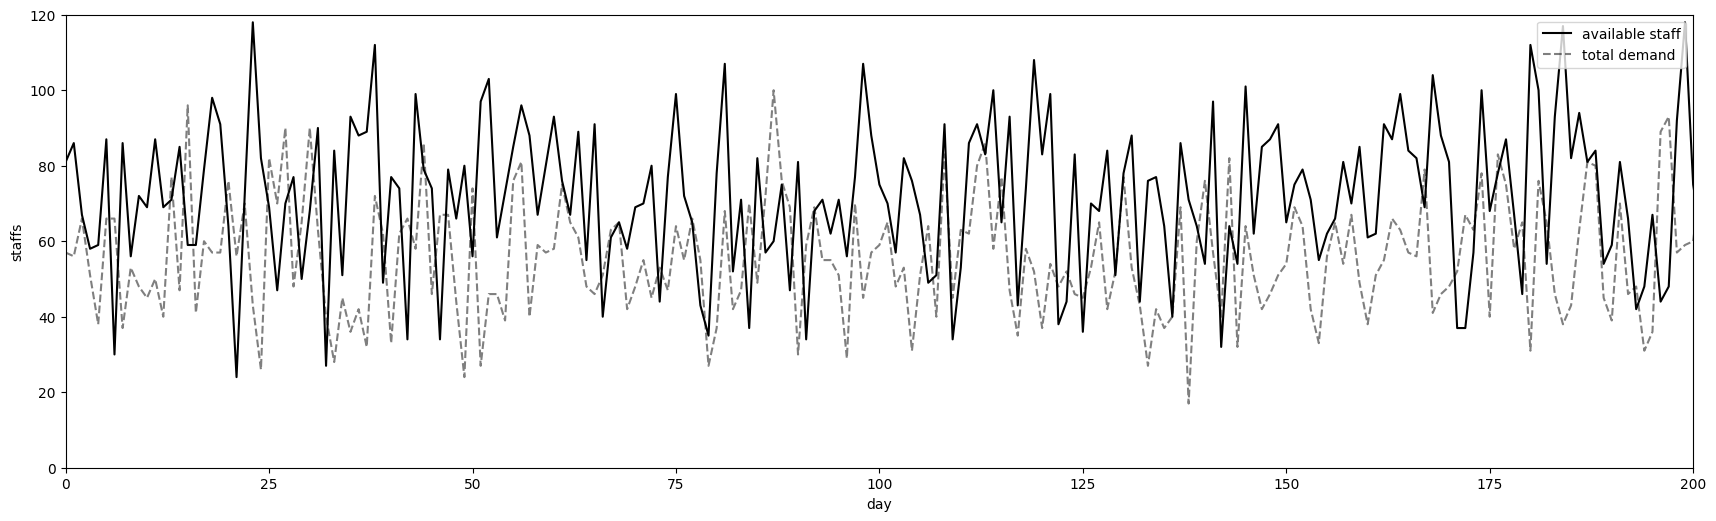

Mean staffs: 71.757
Mean staff demand: 55.861


In [19]:
# Some comparision for demand and supply
samples_staff = []
samples_demand = []
for i in range(1000):
  input_data = create_input_data()
  samples_staff.append(input_data['total_staff'])
  samples_demand.append(sum(input_data['staff_needed_per_asset']))
figure(num=None, figsize=(21, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(samples_staff, 'black', label = 'available staff')
plt.plot(samples_demand,'k--',alpha=0.5,label = 'total demand')
plt.legend(loc='upper right')
plt.ylabel('staffs')
plt.xlabel('day')
plt.xlim([0,200])
plt.ylim([0,120])
plt.show()
print("Mean staffs:", sum(samples_staff)/1000)
print("Mean staff demand:", sum(samples_demand)/1000)

# Visualization
Compare staff deployed and left onshore and number of vehicles used and sitting idle 

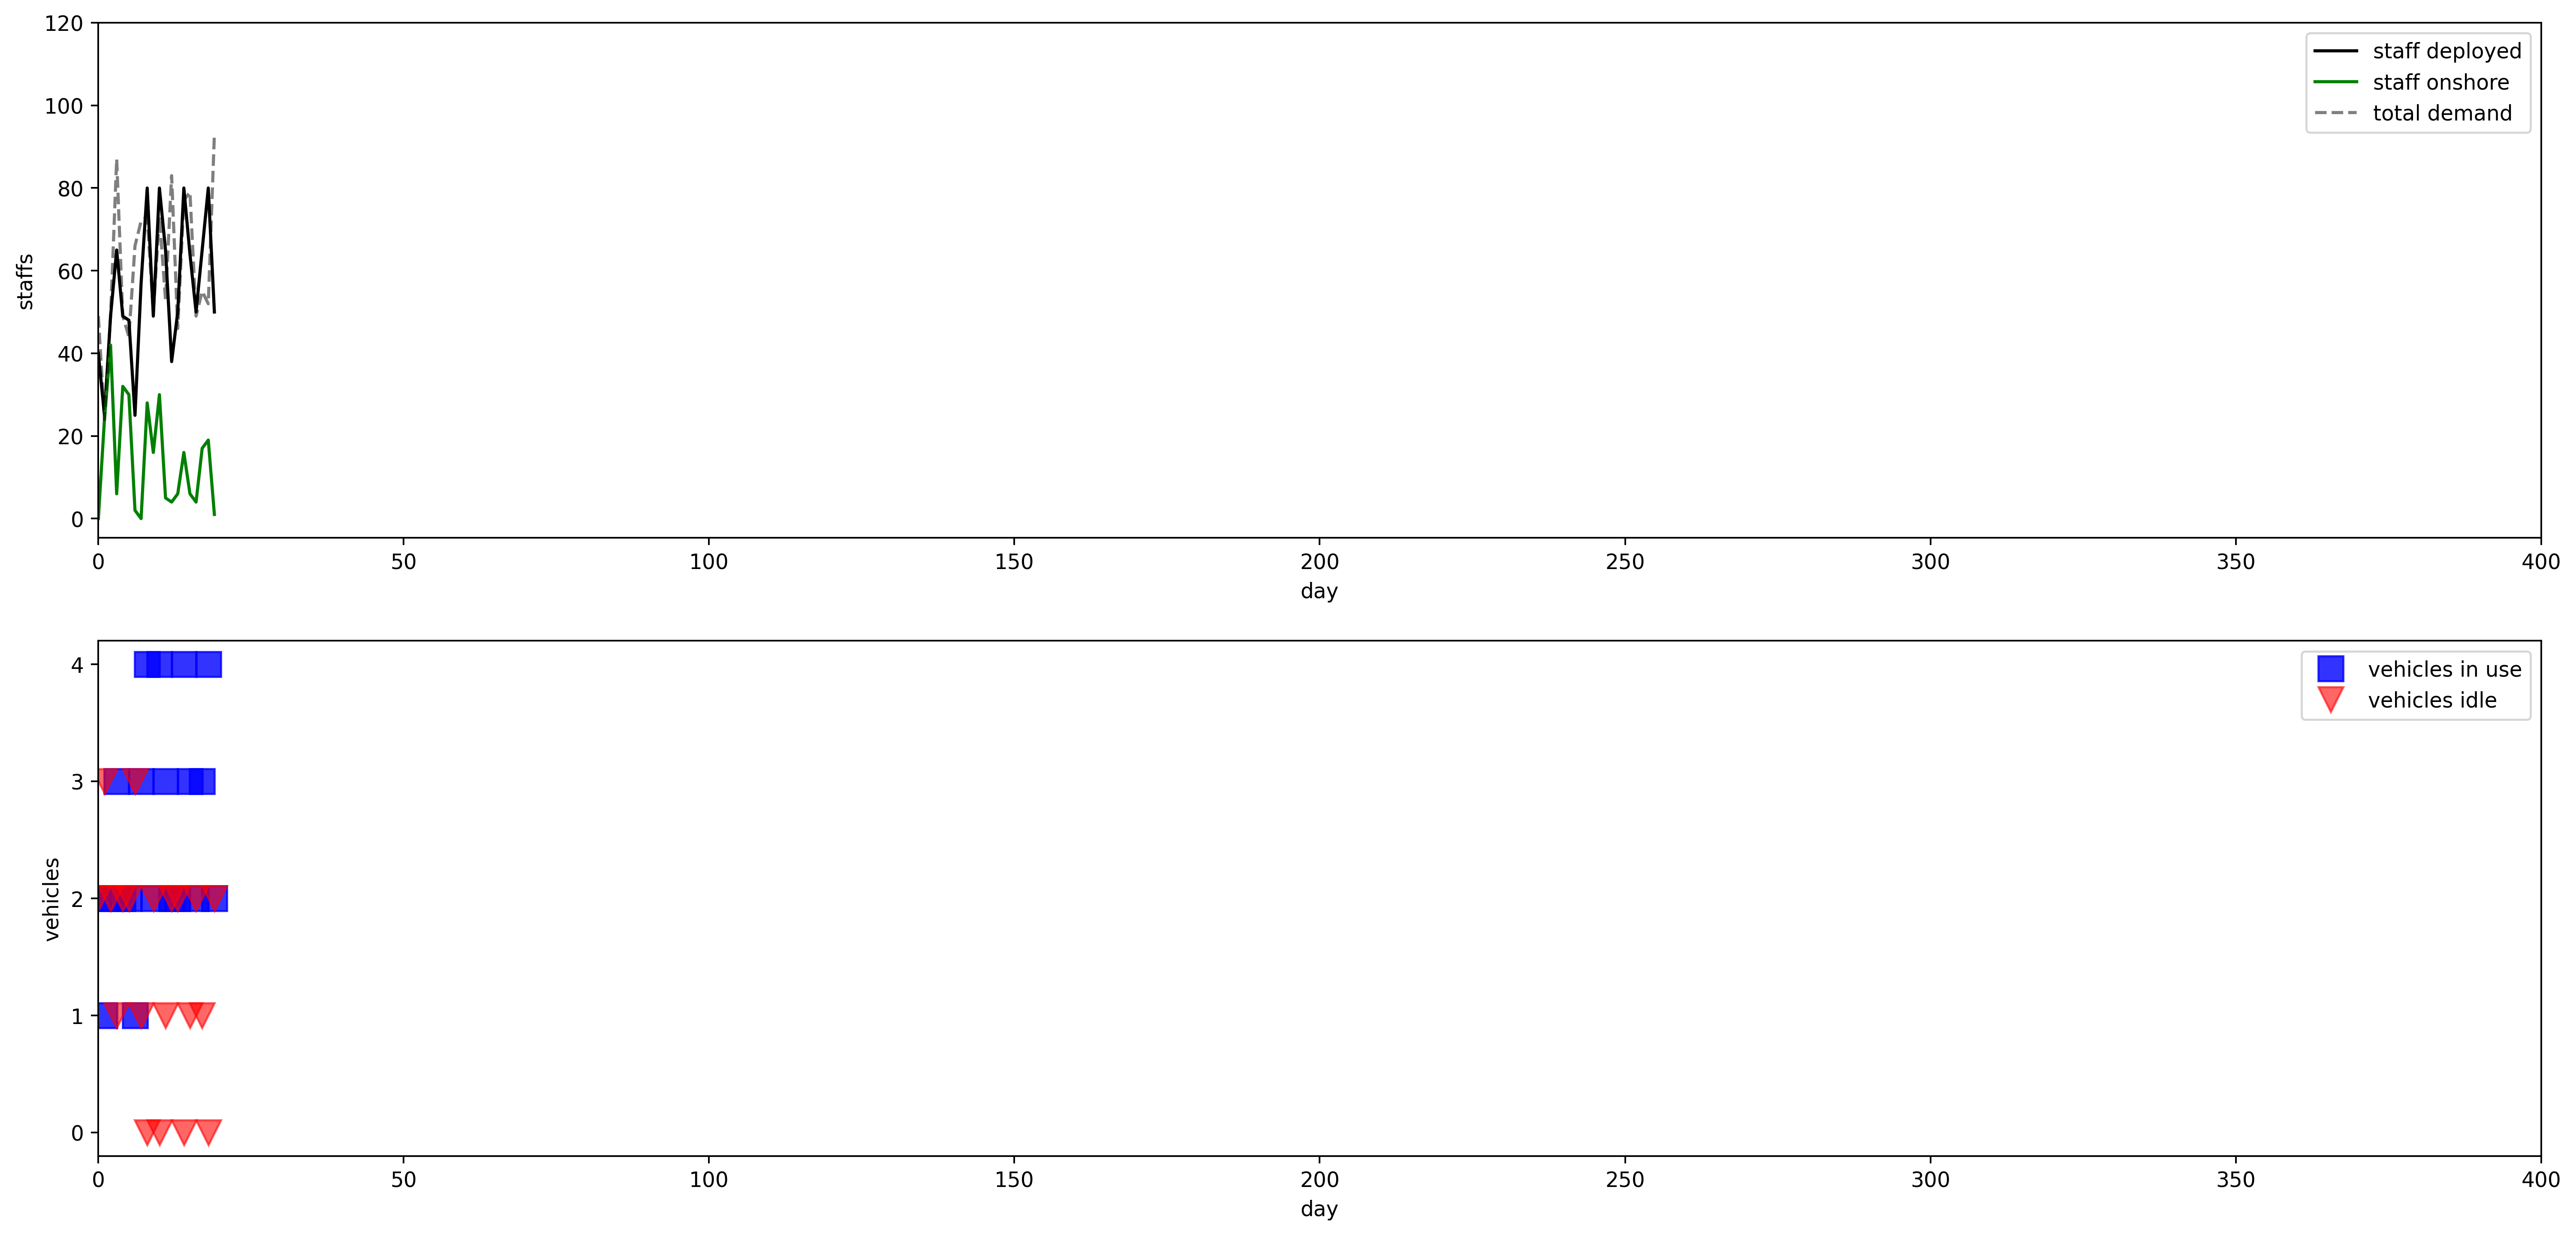

In [20]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(21,10), dpi=350)
ax1.plot(staff_deployed, 'k', label = 'staff deployed')
ax1.plot(staff_unused, 'g', label = 'staff onshore')
ax1.plot(total_demand,'k--', alpha=0.5, label = 'total demand')
ax1.legend(loc='upper right')
ax1.set_xlabel("day")
ax1.set_ylabel("staffs")
ax1.set_xlim([0,400])
ax1.set_yticks([0,20,40,60,80,100,120])
ax2.plot(vehicle_deployed,'bs',alpha=0.8,markersize=12, label = "vehicles in use")
ax2.plot(vehicle_idle,'rv',alpha =0.6,markersize=12, label = "vehicles idle")
ax2.set_xlabel("day")
ax2.set_ylabel("vehicles")
ax2.set_yticks([0,1,2,3,4])
ax2.set_xlim([0,400])
ax2.legend(loc='upper right')

# Compute key metrics
1. Days with idle helicopter
2. Percent demand met for high and low priority location 
3. Percent team sent when there was a demand

## Compare the vehicle capaicity in use with total demand.
Check if there are empty seats in vehicle

No of days with idle vehicle: 16
capacity in use: [40, 25, 50, 65, 50, 50, 25, 65, 80, 50, 80, 65, 40, 50, 80, 65, 50, 65, 80, 50]
One vehicle: 5
two vehicle: 9
three vehicle: 2
demand met low: 65
total demand low: 85
Percent demand met low: 76.47058823529412
demand met high: 47
total demand high: 60
Percent demand met high: 78.33333333333333
team sent low: 98.82352941176471
team sent high: 100.0


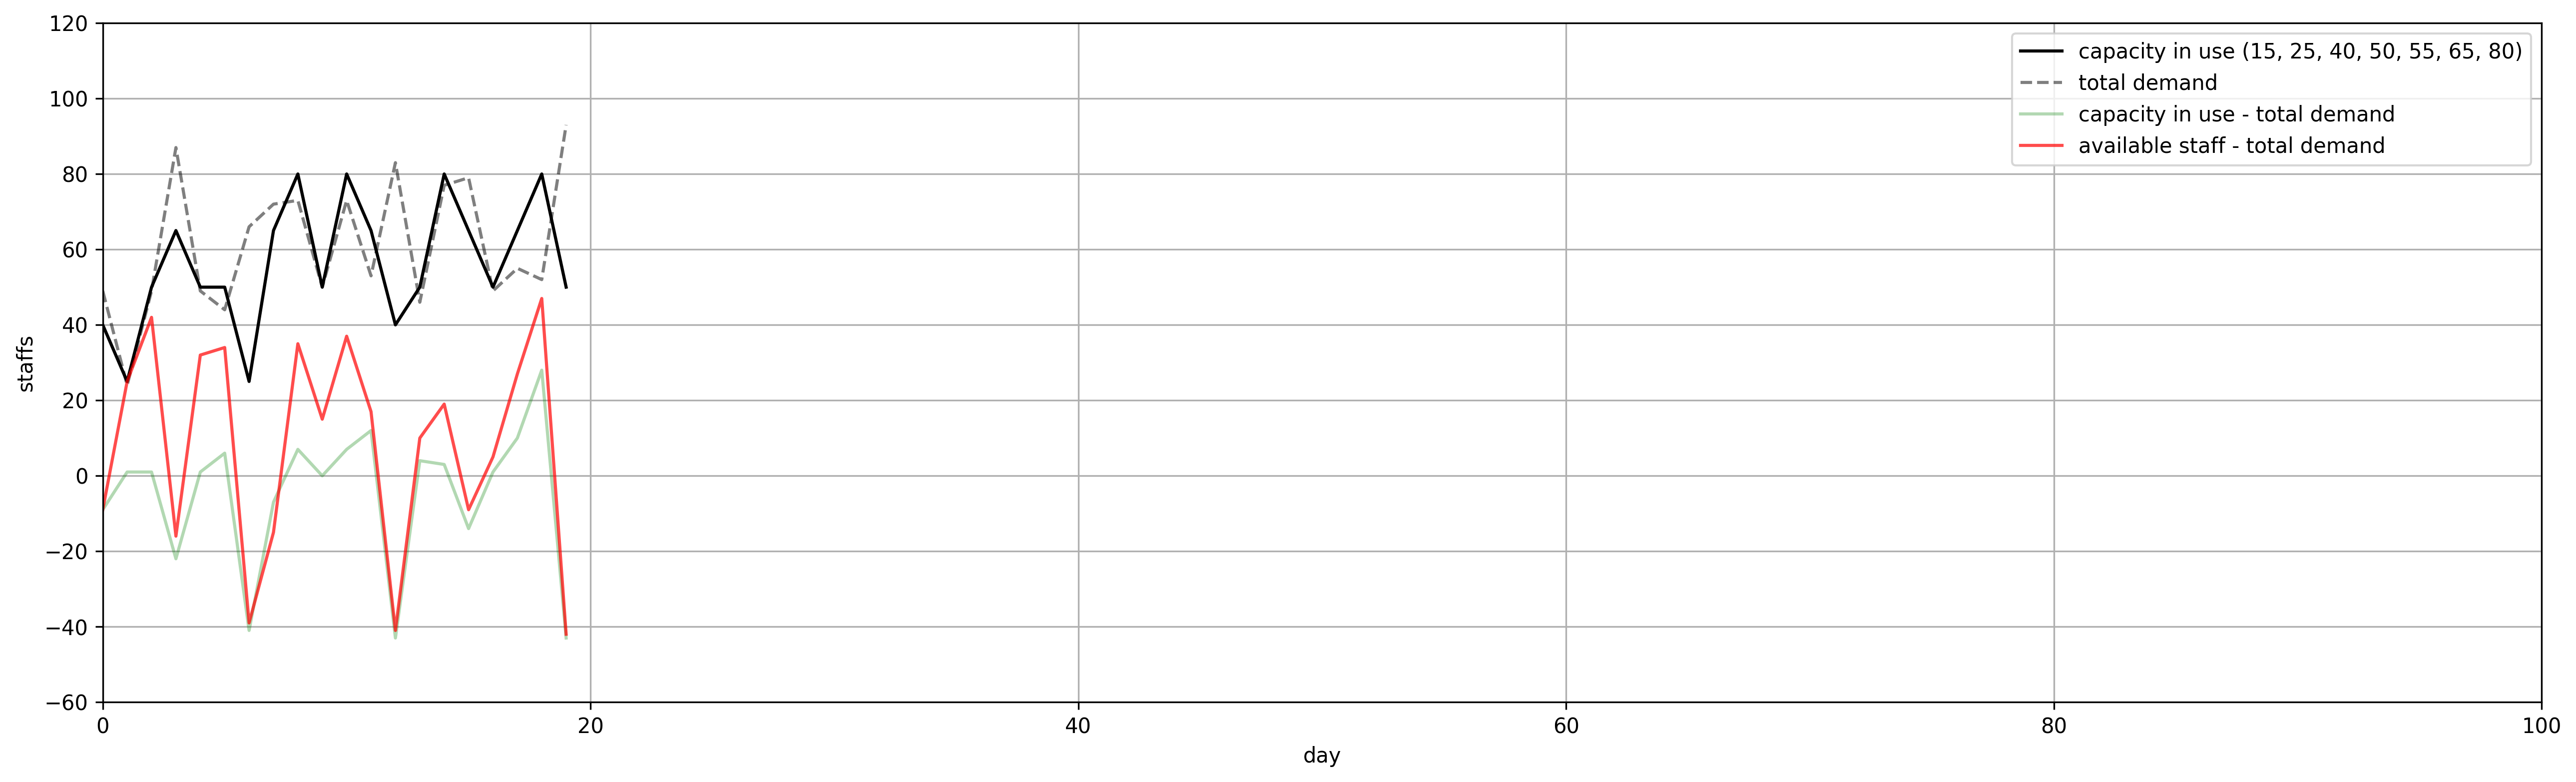

In [22]:
# # Key metrics
# Days with idle helicopters
days_idle_vehicle = 0
for i in range(len(vehicle_idle)):
  if(vehicle_idle[i]>0):
    days_idle_vehicle = days_idle_vehicle + 1
print("No of days with idle vehicle:", days_idle_vehicle)
# vehicle capacity in use
capacity_in_use = []
for i in range(len(selected_vehicles)):
  temp = 0
  for j in range(len(selected_vehicles[i])):
    if (selected_vehicles[i][j] >15):
      temp = temp+25
    else:
      temp = temp+15
  capacity_in_use.append(temp)
print("capacity in use:", capacity_in_use)

one_vehicle = 0 
two_vehicle = 0
three_vehicle = 0
for i in capacity_in_use:
  if (80 - i == 15 or 80-i==25):
    one_vehicle = one_vehicle + 1
  elif (80-i == 40 or 80 - i == 50 or 80-i==30):
    two_vehicle =two_vehicle +1
  elif(80- i == 65 or 80 - i == 55):
    three_vehicle = three_vehicle +1

print("One vehicle:", one_vehicle)
print("two vehicle:", two_vehicle)
print("three vehicle:", three_vehicle)

fig, (ax1) = plt.subplots(1,figsize=(21,6), dpi=300)
ax1.plot(capacity_in_use,'k', alpha=1, label = 'capacity in use (15, 25, 40, 50, 55, 65, 80)')
ax1.plot(total_demand, 'k--', alpha = 0.5, label = 'total demand')
ax1.plot([ x-y for x,y in zip(capacity_in_use,total_demand)], 'g', alpha = 0.3, label = 'capacity in use - total demand')
ax1.plot([ y-x for x,y in zip(total_demand,available_staff)], 'r', alpha = 0.7, label = 'available staff - total demand')
ax1.grid(True)
# ax1.plot(available_staff,'b--', alpha=0.8, label = 'available staff')

ax1.legend(loc='upper right')
ax1.set_xlabel("day")
ax1.set_ylabel("staffs")
ax1.set_xlim([0,100])
ax1.set_yticks([-60,-40,-20,0,20,40,60,80,100,120])
    
asset_priority = [1,1,2,2,2,1,1,2,1,1]
# Demand met at low production locations
demand_low = 0
demand_met_low = 0
demand_high = 0
demand_met_high = 0
for i in range(len(teams_composition)):
  for j in range(len(teams_composition[i])):
    if (demand_per_asset[i][j]>0):
      if (asset_priority[j] ==1):
        demand_low =demand_low+1
        if (sum(teams_composition[i][j])>=demand_per_asset[i][j]):
          demand_met_low  = demand_met_low + 1
      else:
        demand_high = demand_high + 1
        if (sum(teams_composition[i][j])>=demand_per_asset[i][j]):
          demand_met_high  = demand_met_high + 1
print("demand met low:", demand_met_low)
print("total demand low:", demand_low)
print("Percent demand met low:", demand_met_low*100/demand_low)
print("demand met high:", demand_met_high)
print("total demand high:", demand_high)
print("Percent demand met high:", demand_met_high*100/demand_high)

# team sent at low demand location
team_sent_low = 0
team_sent_high = 0
for i in range(len(teams_composition)):
  for j in range(len(teams_composition[i])):
    if (demand_per_asset[i][j]>0):
      if (asset_priority[j] ==1):
        if (sum(teams_composition[i][j])>0):
          team_sent_low  = team_sent_low + 1
      else:
        if (sum(teams_composition[i][j])>0):
          team_sent_high  = team_sent_high + 1
print("team sent low:", team_sent_low*100/demand_low)
print("team sent high:", team_sent_high*100/demand_high)


## Data when demand was 1.5 times the supply. 
Check how much percentage of location recieved at least one team

In [23]:
# Days with demand is 2x the supply
demand_per_asset_rare = []
selected_vehicles_rare = []
teams_composition_rare = []
available_staff_rare = []
total_demand_rare = []
factor = 1.5
for i in range(len(available_staff)):
  if (total_demand[i]>factor*available_staff[i]):
    demand_per_asset_rare.append(demand_per_asset[i])
    selected_vehicles_rare.append(selected_vehicles[i])
    teams_composition_rare.append(teams_composition[i])
    available_staff_rare.append(available_staff[i])
    total_demand_rare.append(total_demand[i])

print(available_staff_rare)
print(total_demand_rare)
print(demand_per_asset_rare)
# print(selected_vehicles_rare)
print(teams_composition_rare)

[27, 42, 51]
[66, 83, 93]
[[2, 0, 12, 9, 12, 0, 7, 9, 9, 6], [0, 0, 15, 11, 11, 9, 10, 14, 13, 0], [14, 4, 10, 12, 6, 3, 12, 6, 12, 14]]
[[[2], [0], [3, 3, 3, 2, 1], [2, 2, 2, 0], [1, 0, 0], [0], [1], [1], [2], [0]], [[0], [0], [4, 4, 3, 3, 0], [4, 3, 3, 1], [2, 2, 2, 1], [1, 1, 0, 0], [1], [2], [1], [0]], [[4, 4, 4, 0], [4], [3, 3, 1, 0], [3, 3, 2, 2, 2], [2, 2, 2], [2], [1, 0], [3], [2], [1]]]


In [ ]:
len(available_staff_rare)

27

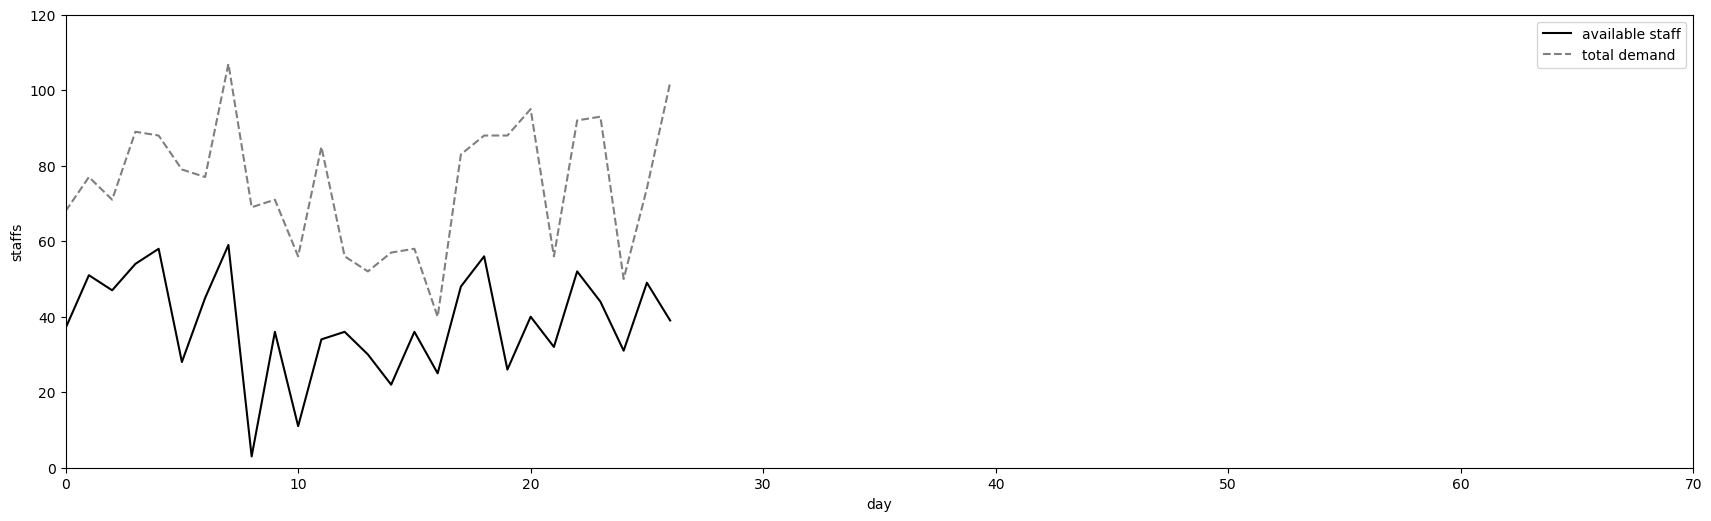

In [ ]:
figure(num=None, figsize=(21, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(available_staff_rare, 'black', label = 'available staff')
plt.plot(total_demand_rare,'k--',alpha=0.5,label = 'total demand')
plt.legend(loc='upper right')
plt.ylabel('staffs')
plt.xlabel('day')
plt.xlim([0,70])
plt.ylim([0,120])
plt.show()


In [ ]:
# Demand met at low production locations
demand_low_rare = 0
demand_met_low_rare = 0
demand_high_rare = 0
demand_met_high_rare = 0
for i in range(len(teams_composition_rare)):
  for j in range(len(teams_composition_rare[i])):
    if (demand_per_asset_rare[i][j]>0):
      if (asset_priority[j] ==1):
        demand_low_rare =demand_low_rare+1
        if (sum(teams_composition_rare[i][j])>=demand_per_asset_rare[i][j]):
          demand_met_low_rare  = demand_met_low_rare + 1
      else:
        demand_high_rare = demand_high_rare + 1
        if (sum(teams_composition_rare[i][j])>=demand_per_asset_rare[i][j]):
          demand_met_high_rare  = demand_met_high_rare + 1
print("demand met low rare:", demand_met_low_rare)
print("total demand low rare:", demand_low_rare)
print("Percent demand met low rare:", demand_met_low_rare*100/demand_low_rare)
print("demand met high rare:", demand_met_high_rare)
print("total demand high rare:", demand_high_rare)
print("Percent demand met high rare:", demand_met_high_rare*100/demand_high_rare)


# team sent at low demand location
team_sent_low_rare = 0
team_sent_high_rare = 0
for i in range(len(teams_composition_rare)):
  for j in range(len(teams_composition_rare[i])):
    if (demand_per_asset_rare[i][j]>0):
      if (asset_priority[j] ==1):
        if (sum(teams_composition_rare[i][j])>0):
          team_sent_low_rare  = team_sent_low_rare + 1
      else:
        if (sum(teams_composition_rare[i][j])>0):
          team_sent_high_rare  = team_sent_high_rare + 1
print("team sent low rare:", team_sent_low_rare*100/demand_low_rare)
print("team sent high rare:", team_sent_high_rare*100/demand_high_rare)

demand met low rare: 38
total demand low rare: 130
Percent demand met low rare: 29.23076923076923
demand met high rare: 29
total demand high rare: 89
Percent demand met high rare: 32.58426966292135
team sent low rare: 92.3076923076923
team sent high rare: 93.25842696629213
